In [70]:
# --- Parameter wie in der Kommandozeile ---
n = 10
mode = 'random'        # 'random' oder 'roundtrip'
density = 0.6
loop_prob = 0.001
max_dead_ends = 0
spread_bias = 1.0
time_limit = 5.0
output_format = 'hermann'  # 'human' oder 'hermann'
output_file = "ascii-maze.txt"

import random
import time
import os

CHAR_STRAIGHT_H = '─'
CHAR_STRAIGHT_V = '│'
CHAR_CURVE_SE    = '┌'
CHAR_CURVE_SW    = '┐'
CHAR_CURVE_NE    = '└'
CHAR_CURVE_NW    = '┘'
CHAR_T_DOWN      = '┬'
CHAR_T_UP        = '┴'
CHAR_T_RIGHT     = '├'
CHAR_T_LEFT      = '┤'
CHAR_CROSS       = '┼'
EMPTY_CHAR       = ' '

CONNECTIONS_TO_CHAR = {
    frozenset(['W','E']): CHAR_STRAIGHT_H,
    frozenset(['N','S']): CHAR_STRAIGHT_V,
    frozenset(['S','E']): CHAR_CURVE_SE,
    frozenset(['S','W']): CHAR_CURVE_SW,
    frozenset(['N','E']): CHAR_CURVE_NE,
    frozenset(['N','W']): CHAR_CURVE_NW,
    frozenset(['S','W','E']): CHAR_T_DOWN,
    frozenset(['N','W','E']): CHAR_T_UP,
    frozenset(['N','S','E']): CHAR_T_RIGHT,
    frozenset(['N','S','W']): CHAR_T_LEFT,
    frozenset(['N','S','W','E']): CHAR_CROSS,
}

def adjacency_to_char(adj, i, j):
    return CONNECTIONS_TO_CHAR.get(frozenset(adj.get((i,j), set())), EMPTY_CHAR)

def fix_dead_ends_expand(adj, n, selected, max_dead_ends=0, allow_expand=True, max_expand=None):
    changed = True
    expand_count = 0
    while changed:
        dead_ends = [(i,j) for (i,j) in list(selected) if len(adj.get((i,j), set())) == 1]
        if len(dead_ends) <= max_dead_ends:
            break
        changed = False
        for (i,j) in dead_ends:
            if len(dead_ends) <= max_dead_ends:
                break
            conns = adj.get((i,j), set())
            dirs = [('N',(-1,0)),('S',(1,0)),('W',(0,-1)),('E',(0,1))]
            random.shuffle(dirs)
            connected = False
            for d,(di,dj) in dirs:
                ni, nj = i+di, j+dj
                if 0 <= ni < n and 0 <= nj < n and (ni,nj) in selected and d not in conns:
                    adj.setdefault((i,j), set()).add(d)
                    opp = {'N':'S','S':'N','W':'E','E':'W'}[d]
                    adj.setdefault((ni,nj), set()).add(opp)
                    changed = True
                    connected = True
                    break
            if connected:
                continue
            if allow_expand:
                for d,(di,dj) in dirs:
                    ni, nj = i+di, j+dj
                    if 0 <= ni < n and 0 <= nj < n and (ni,nj) not in selected:
                        adj.setdefault((i,j), set()).add(d)
                        opp = {'N':'S','S':'N','W':'E','E':'W'}[d]
                        adj.setdefault((ni,nj), set()).add(opp)
                        selected.add((ni,nj))
                        expand_count += 1
                        changed = True
                        break
                if max_expand is not None and expand_count >= max_expand:
                    allow_expand = False
    return adj, selected

def generate_random_connected(n, density, loop_prob, max_dead_ends, spread_bias):
    total = n*n
    target = max(1, int(total * density))
    adj = {}
    cells = [(random.randrange(n), random.randrange(n))]
    selected = {cells[0]}
    while len(selected) < target:
        if spread_bias > 0 and cells:
            scores = []
            for (i,j) in cells:
                cnt = 0
                for (di,dj) in [(-1,0),(1,0),(0,-1),(0,1)]:
                    ni, nj = i+di, j+dj
                    if (ni,nj) in selected:
                        cnt += 1
                scores.append((cnt, (i,j)))
            scores.sort(key=lambda x: x[0])
            cutoff = max(1, int(len(scores) * spread_bias))
            _, (i,j) = random.choice(scores[:cutoff])
        else:
            i,j = random.choice(cells)
        dirs = [('N',(-1,0)),('S',(1,0)),('W',(0,-1)),('E',(0,1))]
        random.shuffle(dirs)
        found = False
        for d,(di,dj) in dirs:
            ni, nj = i+di, j+dj
            if 0 <= ni < n and 0 <= nj < n and (ni, nj) not in selected:
                adj.setdefault((i,j), set()).add(d)
                opp = {'N':'S','S':'N','W':'E','E':'W'}[d]
                adj.setdefault((ni,nj), set()).add(opp)
                selected.add((ni,nj))
                cells.append((ni,nj))
                found = True
                break
        if not found:
            new_cells = []
            for (ci,cj) in cells:
                for (di,dj) in [(-1,0),(1,0),(0,-1),(0,1)]:
                    ni, nj = ci+di, cj+dj
                    if 0 <= ni < n and 0 <= nj < n and (ni,nj) not in selected:
                        new_cells.append((ci,cj))
                        break
            cells = new_cells
            if not cells:
                break
    for i,j in list(selected):
        for d,(di,dj) in [('N',(-1,0)),('S',(1,0)),('W',(0,-1)),('E',(0,1))]:
            ni, nj = i+di, j+dj
            if 0 <= ni < n and 0 <= nj < n and (ni,nj) in selected:
                if d not in adj.get((i,j), set()) and random.random() < loop_prob:
                    adj.setdefault((i,j), set()).add(d)
                    opp = {'N':'S','S':'N','W':'E','E':'W'}[d]
                    adj.setdefault((ni,nj), set()).add(opp)
    if max_dead_ends >= 0:
        adj, selected = fix_dead_ends_expand(adj, n, selected, max_dead_ends, allow_expand=True, max_expand=None)
    return adj

def build_cycle(n, target_len, time_limit):
    start = time.time()
    dirs = [('N',(-1,0)),('S',(1,0)),('W',(0,-1)),('E',(0,1))]
    def neighbors(i,j):
        for d,(di,dj) in dirs:
            ni, nj = i+di, j+dj
            if 0 <= ni < n and 0 <= nj < n:
                yield d, ni, nj
    for attempt in range(100):
        visited = [[False]*n for _ in range(n)]
        path = []
        si, sj = random.randrange(n), random.randrange(n)
        visited[si][sj] = True
        path.append((si,sj))
        start_time = time.time()
        def dfs(i,j,depth):
            if time.time() - start_time > time_limit:
                return False
            if depth == target_len:
                for d, ni, nj in neighbors(i,j):
                    if (ni, nj) == (si, sj):
                        path.append((i,j))
                        return True
                return False
            for d, ni, nj in random.sample(list(neighbors(i,j)), len(list(neighbors(i,j)))):
                if not visited[ni][nj]:
                    visited[ni][nj] = True
                    path.append((i,j))
                    if dfs(ni, nj, depth+1):
                        return True
                    path.pop()
                    visited[ni][nj] = False
            return False
        if dfs(si, sj, 1):
            adj = {}
            for idx in range(len(path)-1):
                i,j = path[idx]
                ni,nj = path[idx+1]
                if ni == i-1 and nj == j: d='N'
                elif ni == i+1 and nj == j: d='S'
                elif ni == i and nj == j-1: d='W'
                elif ni == i and nj == j+1: d='E'
                else: continue
                adj.setdefault((i,j), set()).add(d)
                opp = {'N':'S','S':'N','W':'E','E':'W'}[d]
                adj.setdefault((ni,nj), set()).add(opp)
            i,j = path[-1]
            if si == i-1 and sj == j: d='N'
            elif si == i+1 and sj == j: d='S'
            elif si == i and sj == j-1: d='W'
            elif si == i and sj == j+1: d='E'
            else: d=None
            if d:
                adj.setdefault((i,j), set()).add(d)
                opp = {'N':'S','S':'N','W':'E','E':'W'}[d]
                adj.setdefault((si,sj), set()).add(opp)
            return adj
    return None

def adjacency_to_grid(adj, n):
    grid = []
    for i in range(n):
        row = []
        for j in range(n):
            row.append(adjacency_to_char(adj, i, j))
        grid.append(row)
    return grid

def save_map_text(filename, adj, n):
    border = '#' * n
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(border + "\n")
        f.write(f"# Size: {n} {n}\n")
        f.write("# Legend:\n")
        f.write(f"# {CHAR_STRAIGHT_H} : EW\n")
        f.write(f"# {CHAR_STRAIGHT_V} : NS\n")
        f.write(f"# {CHAR_CURVE_SE} : SE\n")
        f.write(f"# {CHAR_CURVE_SW} : SW\n")
        f.write(f"# {CHAR_CURVE_NE} : NE\n")
        f.write(f"# {CHAR_CURVE_NW} : NW\n")
        f.write(f"# {CHAR_T_DOWN} : T-down (S,W,E)\n")
        f.write(f"# {CHAR_T_UP} : T-up (N,W,E)\n")
        f.write(f"# {CHAR_T_RIGHT} : T-right (N,S,E)\n")
        f.write(f"# {CHAR_T_LEFT} : T-left (N,S,W)\n")
        f.write(f"# {CHAR_CROSS} : crossroad (N,S,W,E)\n")
        f.write(f"# {EMPTY_CHAR!r} : empty\n")
        f.write(border + "\n")
        for i in range(n):
            row = ''.join(adjacency_to_char(adj, i, j) for j in range(n))
            f.write(row + "\n")
        f.write(border + "\n")

def save_map_python(filename, adj, n):
    grid = adjacency_to_grid(adj, n)
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("grid = [\n")
        for row in grid:
            f.write("    " + repr(row) + ",\n")
        f.write("]\n")

# --- Hauptlogik wie main() ---
if n < 2:
    raise ValueError("n muss >= 2 sein")

# Stelle sicher, dass der output-Ordner existiert
os.makedirs("output", exist_ok=True)
output_file_path = os.path.join("../output", os.path.basename(output_file))

if mode in ('random','r'):
    adj = generate_random_connected(n, density, loop_prob, max_dead_ends, spread_bias)
else:
    target = max(4, int(n*n * density))
    adj = build_cycle(n, target, time_limit)
    if adj is None:
        raise RuntimeError("build_cycle fehlgeschlagen")

if output_format == 'human':
    save_map_text(output_file_path, adj, n)
else:
    save_map_python(output_file_path, adj, n)

with open(output_file_path, "r", encoding="utf-8") as f:
    ascii_maze = f.read()

print(f"✅ Map wurde als '{output_file_path}' gespeichert.")

✅ Map wurde als '../output/ascii-maze.txt' gespeichert.


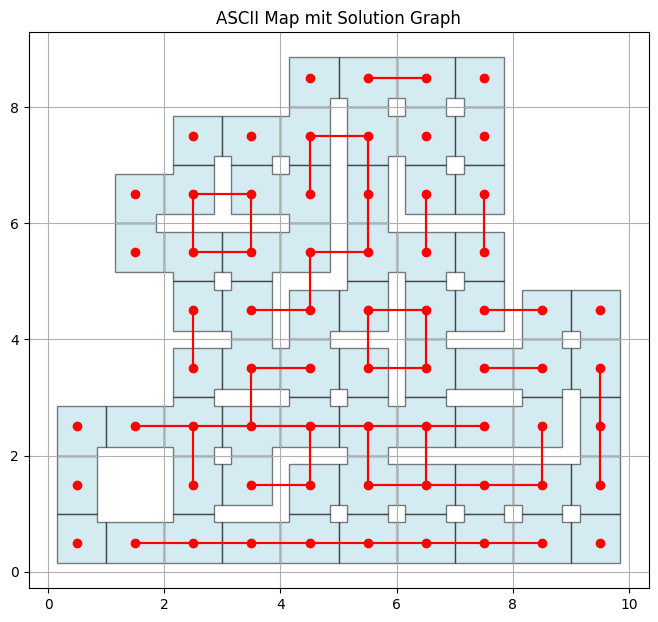

In [ ]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# === SolutionGraphNode-Klasse ===
class SolutionGraphNode:
    def __init__(self, coord):
        self.coordinate = coord     # (x, y)
        self.neighbors = []         # Liste weiterer SolutionGraphNode

# Deine ASCII-Map als Grid
with open('../output/ascii-maze.txt', encoding='utf-8') as f:
    exec(f.read())

cell_size = 1.0
margin = 0.15  # halbe Straßenbreite

def symbol_to_polygon(i, j, symbol, rows, cols, cell_size=1.0, m=0.1):
    x0 = j * cell_size
    y0 = (rows - 1 - i) * cell_size
    x1 = x0 + cell_size
    y1 = y0 + cell_size
    xm = x0 + m
    xM = x1 - m
    ym = y0 + m
    yM = y1 - m

    if symbol == '─':
        return Polygon([(x0, ym), (x1, ym), (x1, yM), (x0, yM)])
    elif symbol == '│':
        return Polygon([(xm, y0), (xM, y0), (xM, y1), (xm, y1)])
    elif symbol == '┌':
        return Polygon([(xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (xm, yM)])
    elif symbol == '┐':
        return Polygon([(x0, yM), (xM, yM), (xM, y0), (xm, y0), (xm, ym), (x0, ym)])
    elif symbol == '└':
        return Polygon([(xm, y1), (xm, ym), (x1, ym), (x1, yM), (xM , yM), (xM, y1)])
    elif symbol == '┘':
        return Polygon([(x0, ym), (xM, ym), (xM, y1), (xm, y1), (xm, yM), (x0, yM)])
    elif symbol == '├':
        return Polygon([(xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (xM, yM), (xM, y1), (xm, y1)])
    elif symbol == '┤':
        return Polygon([(xm, y0), (xM, y0), (xM, y1), (xm, y1), (xm, yM), (x0, yM), (x0, ym), (xm, ym)])
    elif symbol == '┬':
        return Polygon([(x0, ym), (xm, ym), (xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (x0, yM)])
    elif symbol == '┴':
        return Polygon([(x0, ym), (x1, ym), (x1, yM), (xM, yM), (xM, y1), (xm, y1), (xm, yM), (x0, yM)])
    elif symbol == '┼':
        return Polygon([(xm, y0), (xM, y0), (xM, ym), (x1, ym), (x1, yM), (xM, yM), (xM, y1),
                        (xm, y1), (xm, yM), (x0, yM), (x0, ym), (xm, ym)])
    return None

def ascii_grid_to_polygons(grid, cell_size=1.0, margin=0.1):
    rows = len(grid)
    cols = len(grid[0])
    polygons = []
    for i in range(rows):
        for j in range(cols):
            symbol = grid[i][j]
            poly = symbol_to_polygon(i, j, symbol, rows, cols, cell_size, margin)
            if poly:
                polygons.append(poly)
    return polygons

def build_solution_graph(grid, cell_size=1.0):
    rows, cols = len(grid), len(grid[0])
    node_map = {}

    # Richtungsoffsets
    dirs = {'N':(-1,0), 'S':(1,0), 'W':(0,-1), 'E':(0,1)}
    opposite = {'N':'S','S':'N','W':'E','E':'W'}

    # Welche Symbole können in welche Richtung weiterführen?
    allows = {
        'N': {'│','┤','├','┼','┴','┘','└'},
        'S': {'│','┤','├','┼','┬','┐','┌'},
        'E': {'─','┬','┴','┼','┌','└','├'},
        'W': {'─','┬','┴','┼','┐','┘','┤'},
    }

    def open_dirs(i, j):
        """Gibt Liste der Richtungen zurück, in die von Zelle (i,j) sofort weitergefahren werden kann."""
        res = []
        sym = grid[i][j]
        for d, (di, dj) in dirs.items():
            ni, nj = i+di, j+dj
            # Symmetrische Prüfung: diese Zelle muss Ausfahrt in d haben,
            # und Nachbarzelle muss Einfahrt aus opposite[d] erlauben.
            if (sym in allows[d]
                and 0 <= ni < rows and 0 <= nj < cols
                and grid[ni][nj] in allows[opposite[d]]):
                res.append(d)
        return res

    # 1) Zuerst alle Knoten anlegen (einschließlich gerader Segmente, wenn du willst)
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] in {'─','│','┌','┐','└','┘','├','┤','┬','┴','┼'}:
                x = j*cell_size + cell_size/2
                y = (rows-1 - i)*cell_size + cell_size/2
                node_map[(i,j)] = SolutionGraphNode((x,y))

    # 2) Jetzt nur noch bestehende Knoten *verlinken*, nicht neue erzeugen
    for (i, j), node in node_map.items():
        for d in open_dirs(i, j):
            di, dj = dirs[d]
            ni, nj = i + di, j + dj
            # wenn die Nachbarzelle ebenfalls ein Knoten ist, verlinke
            if (ni, nj) in node_map:
                neighbor = node_map[(ni, nj)]
                node.neighbors.append(neighbor)
                # und bidirektional, falls gewünscht:
                # neighbor.neighbors.append(node)

    return list(node_map.values())


# Haupt-Code in Jupyter-Style
polys = ascii_grid_to_polygons(grid, cell_size, margin)
solution_graph = build_solution_graph(grid, cell_size)

# Plot-Funktion erweitert
fig, ax = plt.subplots(figsize=(8,8))
for poly in polys:
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.5, fc='lightblue', ec='black')

# Graph-Knoten & -Kanten plotten
for node in solution_graph:
    x0, y0 = node.coordinate
    ax.plot(x0, y0, 'ro')
    for nb in node.neighbors:
        x1, y1 = nb.coordinate
        ax.plot([x0, x1], [y0, y1], 'r-')

ax.set_aspect('equal')
ax.set_title("ASCII Map mit Solution Graph")
plt.grid(True)
plt.show()

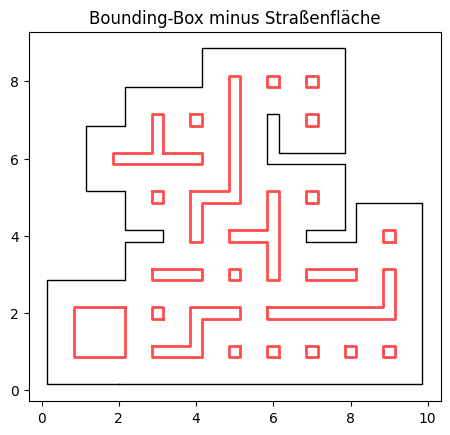

In [72]:
from shapely.geometry import box
from shapely.ops import unary_union

# Angenommen, `grid_polys` ist die Liste aller Straßen-Polygone,
# erzeugt z.B. durch ascii_grid_to_polygons(...)
# und grid hat die Abmessungen rows×cols.

rows = len(grid)
cols = len(grid[0])
cell_size = 1.0

# 1. Vereine alle Straßen-Segmente in ein Multi-/Polygon
# Erzeuge eine Union der Straßenpolygone, so dass die Löcher (Innenflächen) erhalten bleiben
roads = unary_union(polys)

# Die Löcher (Innenringe) extrahieren:
holes = []
if roads.geom_type == "Polygon":
    for hole in roads.interiors:
        holes.append(Polygon(hole))
elif roads.geom_type == "MultiPolygon":
    for poly in roads.geoms:
        for hole in poly.interiors:
            holes.append(Polygon(hole))
roads = roads.buffer(0)
fig, ax = plt.subplots()

# Löcher (Innenflächen) nur rot umranden, nicht füllen
for hole_poly in holes:
    xh, yh = hole_poly.exterior.xy
    ax.plot(xh, yh, color='red', linewidth=2, alpha=0.7)

# Straßen Scharz umranden
for poly in getattr(roads, 'geoms', [roads]):
    x, y = poly.exterior.xy
    ax.plot(x, y, color='black', linewidth=1)

ax.set_aspect('equal')
ax.set_title("Bounding-Box minus Straßenfläche")
plt.show()

In [73]:
import os

def export_to_cpp(roads, holes, filename="../output/generated_maze.cpp"):
    lines = []
    lines.append('#include <iostream>')
    lines.append('#include <list>')
    lines.append('#include "maze_generator.h"\n')
    lines.append('void MazeGenerator::generateMaze()\n{')
    lines.append('    // --- Straßenpolygone ---')
    # Straßenpolygone
    road_geoms = [roads] if roads.geom_type == 'Polygon' else list(roads.geoms)
    for idx, poly in enumerate(road_geoms):
        var = f"road{idx}"
        lines.append(f"    // {var}")
        lines.append(f"    Mazepolygon {var};")
        coords = list(poly.exterior.coords)[:-1]
        for x, y in coords:
            lines.append(f"        {var}.coordinates.push_back({{{x:.2f}f, {y:.2f}f}});")
        lines.append(f"    polygons.push_back({var});\n")
    # Löcher (Innenflächen)
    lines.append('    // --- Löcher (Innenflächen) ---')
    for idx, poly in enumerate(holes):
        var = f"hole{idx}"
        lines.append(f"    // {var}")
        lines.append(f"    Mazepolygon {var};")
        coords = list(poly.exterior.coords)[:-1]
        for x, y in coords:
            lines.append(f"        {var}.coordinates.push_back({{{x:.2f}f, {y:.2f}f}});")
        lines.append(f"    polygons.push_back({var});\n")
    lines.append('    std::cout << "Maze generated!" << std::endl;')
    lines.append("}\n")
    # Ordner anlegen, falls nicht vorhanden
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "w") as f:
        f.write("\n".join(lines))
    print(f"✅ Exportiert nach {filename}")

# Direkt ausführen:
export_to_cpp(roads, holes)

✅ Exportiert nach ../output/generated_maze.cpp
